In [237]:
!pip install pandas-ta
!pip install yfinance

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)
pd.set_option('display.max_columns', None)

2023-04-27 01:28:34.204893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 01:28:34.431887: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 01:28:35.357626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-27 01:28:35.357702: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

#Alpha vantage

2OQT6WT9WH45WTK5

In [2]:
#df = yf.download(tickers = 'TSLA', start = '2022-03-11',end = '2023-03-11')
company = "TSLA"
Starting = "2020-07-20"
Ending = "2023-04-14"

tickers = yf.Tickers(company)
StockPrice = tickers.tickers[company].history(start=Starting,end=Ending)
StockPrice.index = pd.to_datetime(StockPrice.index).date
StockPrice

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2020-07-20,101.267334,110.000000,99.199997,109.533333,256821000,0.0,0.0
2020-07-21,109.328667,111.666664,103.866669,104.557335,241608000,0.0,0.0
2020-07-22,106.599998,108.428001,104.133331,106.155334,212416500,0.0,0.0
2020-07-23,111.930000,112.599998,98.718002,100.871330,364927500,0.0,0.0
2020-07-24,94.400665,97.666664,91.102669,94.466667,290949000,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-06,183.080002,186.389999,179.740005,185.059998,123857900,0.0,0.0
2023-04-10,179.940002,185.100006,176.110001,184.509995,142154600,0.0,0.0
2023-04-11,186.690002,189.190002,185.649994,186.789993,115770900,0.0,0.0
2023-04-12,190.740005,191.580002,180.309998,180.539993,150256300,0.0,0.0


In [3]:
#df = yf.download(tickers = 'TSLA', start = '2022-03-11',end = '2023-03-11')
company = "TSLA"
Starting = "2020-07-20"
Ending = "2023-04-14"

tickers = yf.Tickers(company)
StockPrice = tickers.tickers[company].history(start=Starting,end=Ending)
StockPrice.index = pd.to_datetime(StockPrice.index).date

Path = f"../Part3_FinBert/output/predictions_{company}.csv"
Sentiment = pd.read_csv(Path).iloc[::-1]\
                            .reset_index()\
                            .drop(['Unnamed: 0', "index"],axis=1)

Sentiment = Sentiment[Sentiment["date"] >= Starting]
Sentiment['date'] = pd.to_datetime(Sentiment['date'])
Sentiment.set_index('date', inplace=True)
Sentiment.index = pd.to_datetime(Sentiment.index).date
Sentiment

,score_title,score_summary
2020-07-20,0.108546,-0.013208
2020-07-21,-0.150379,-0.009721
2020-07-22,-0.147650,0.057897
2020-07-23,0.028656,0.034656
2020-07-24,-0.264506,-0.091593
...,...,...
2023-04-13,0.045576,0.059780
2023-04-14,-0.117404,-0.210186
2023-04-15,-0.094414,-0.103239
2023-04-16,-0.055805,0.140749


In [4]:
missing_rows_index = StockPrice.index.difference(Sentiment.index)
new_data = {'score_title': 0, 'score_summary': 0}
new_row = pd.DataFrame(new_data, index=missing_rows_index)
Sentiment = pd.concat((new_row,Sentiment),axis=0,sort=False)
index_to_keep = pd.Series(True, index=StockPrice.index)
mask = Sentiment.index.isin(index_to_keep.index)
Sentiment = Sentiment[mask]
Full_data = pd.concat((StockPrice,Sentiment),axis=1)
Full_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,score_title,score_summary
2020-07-20,101.267334,110.000000,99.199997,109.533333,256821000,0.0,0.0,0.108546,-0.013208
2020-07-21,109.328667,111.666664,103.866669,104.557335,241608000,0.0,0.0,-0.150379,-0.009721
2020-07-22,106.599998,108.428001,104.133331,106.155334,212416500,0.0,0.0,-0.147650,0.057897
2020-07-23,111.930000,112.599998,98.718002,100.871330,364927500,0.0,0.0,0.028656,0.034656
2020-07-24,94.400665,97.666664,91.102669,94.466667,290949000,0.0,0.0,-0.264506,-0.091593
...,...,...,...,...,...,...,...,...,...
2023-04-06,183.080002,186.389999,179.740005,185.059998,123857900,0.0,0.0,-0.080997,0.019024
2023-04-10,179.940002,185.100006,176.110001,184.509995,142154600,0.0,0.0,-0.066649,-0.001051
2023-04-11,186.690002,189.190002,185.649994,186.789993,115770900,0.0,0.0,-0.112037,-0.080313
2023-04-12,190.740005,191.580002,180.309998,180.539993,150256300,0.0,0.0,0.051657,0.028311


In [5]:
Full_data['RSI']=ta.rsi(Full_data.Close, length=30)
Full_data['EMAF']=ta.ema(Full_data.Close, length=30)
Full_data['EMAM']=ta.ema(Full_data.Close, length=30)
Full_data['EMAS']=ta.ema(Full_data.Close, length=30)


#Full_data['Target'] = Full_data['Close']-Full_data.Open
#Full_data['Target'] = Full_data['Target'].shift(-1)
#Full_data['TargetClass'] = [1 if Full_data.Target[i]>0 else 0 for i in range(len(Full_data))]

Full_data['TargetNextClose'] = Full_data['Close'].shift(-1)
Full_data['TargetNextClose'] = Full_data['Close'].shift(-1)
Full_data
Full_data.iloc[:, 0:-1].dropna(inplace=True)
#Full_data.reset_index(inplace = True)
Full_data.drop(['Volume'], axis=1, inplace=True)
Full_data

,Open,High,Low,Close,Dividends,Stock Splits,score_title,score_summary,RSI,EMAF,EMAM,EMAS,TargetNextClose
2020-07-20,101.267334,110.000000,99.199997,109.533333,0.0,0.0,0.108546,-0.013208,NaN,NaN,NaN,NaN,104.557335
2020-07-21,109.328667,111.666664,103.866669,104.557335,0.0,0.0,-0.150379,-0.009721,NaN,NaN,NaN,NaN,106.155334
2020-07-22,106.599998,108.428001,104.133331,106.155334,0.0,0.0,-0.147650,0.057897,NaN,NaN,NaN,NaN,100.871330
2020-07-23,111.930000,112.599998,98.718002,100.871330,0.0,0.0,0.028656,0.034656,NaN,NaN,NaN,NaN,94.466667
2020-07-24,94.400665,97.666664,91.102669,94.466667,0.0,0.0,-0.264506,-0.091593,NaN,NaN,NaN,NaN,102.639999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,183.080002,186.389999,179.740005,185.059998,0.0,0.0,-0.080997,0.019024,49.882707,189.078367,189.078367,189.078367,184.509995
2023-04-10,179.940002,185.100006,176.110001,184.509995,0.0,0.0,-0.066649,-0.001051,49.712360,188.783633,188.783633,188.783633,186.789993
2023-04-11,186.690002,189.190002,185.649994,186.789993,0.0,0.0,-0.112037,-0.080313,50.438172,188.655011,188.655011,188.655011,180.539993
2023-04-12,190.740005,191.580002,180.309998,180.539993,0.0,0.0,0.051657,0.028311,48.454957,188.131462,188.131462,188.131462,185.899994


In [6]:
data_set = Full_data.iloc[30:-1, 6:14]
data_set

,score_title,score_summary,RSI,EMAF,EMAM,EMAS,TargetNextClose
2020-08-31,0.064944,0.178783,78.587101,115.660970,115.660970,115.660970,158.350006
2020-09-01,0.139595,0.208545,72.223916,118.415101,118.415101,118.415101,149.123337
2020-09-02,-0.175306,0.031887,65.679839,120.396277,120.396277,120.396277,135.666672
2020-09-03,-0.072719,-0.187810,57.780923,121.381464,121.381464,121.381464,139.440002
2020-09-04,-0.066646,-0.387875,59.204111,122.546531,122.546531,122.546531,110.070000
...,...,...,...,...,...,...,...
2023-04-05,0.159216,0.101471,50.021287,189.355496,189.355496,189.355496,185.059998
2023-04-06,-0.080997,0.019024,49.882707,189.078367,189.078367,189.078367,184.509995
2023-04-10,-0.066649,-0.001051,49.712360,188.783633,188.783633,188.783633,186.789993
2023-04-11,-0.112037,-0.080313,50.438172,188.655011,188.655011,188.655011,180.539993


In [7]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled.shape, data_set.columns.shape,data_set.index.shape)
df = pd.DataFrame(data_set_scaled, columns=data_set.columns, index=data_set.index)
df

(658, 7) (7,) (658,)


,score_title,score_summary,RSI,EMAF,EMAM,EMAS,TargetNextClose
2020-08-31,0.568099,0.671994,0.872132,0.000000,0.000000,0.000000,0.166462
2020-09-01,0.611594,0.690165,0.763835,0.011589,0.011589,0.011589,0.135897
2020-09-02,0.428118,0.582304,0.652460,0.019925,0.019925,0.019925,0.091320
2020-09-03,0.487890,0.448165,0.518026,0.024070,0.024070,0.024070,0.103820
2020-09-04,0.491428,0.326013,0.542247,0.028972,0.028972,0.028972,0.006526
...,...,...,...,...,...,...,...
2023-04-05,0.623026,0.624790,0.385962,0.310083,0.310083,0.310083,0.254944
2023-04-06,0.483067,0.574451,0.383604,0.308917,0.308917,0.308917,0.253122
2023-04-10,0.491427,0.562193,0.380705,0.307677,0.307677,0.307677,0.260675
2023-04-11,0.464982,0.513799,0.393057,0.307136,0.307136,0.307136,0.239971


In [8]:
# multiple feature from data provided to the model
X = []
backcandles = 10 # Look back period

print(data_set_scaled.shape[0])
for j in range(6):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X.shape) #658 data, 10 days loop back, 6 indicators
print(y.shape) #Start from 10 days since need 10 to process data

df = pd.DataFrame(y, columns=["Target"], index=df.index[backcandles:])
df

658
(648, 10, 6)
(648, 1)


,Target
2020-09-15,0.129703
2020-09-16,0.109462
2020-09-17,0.130133
2020-09-18,0.138128
2020-09-21,0.110346
...,...
2023-04-05,0.254944
2023-04-06,0.253122
2023-04-10,0.260675
2023-04-11,0.239971


In [9]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

518
(518, 10, 6)
(130, 10, 6)
(518, 1)
(130, 1)


In [10]:
indicators = 6
lstm_input = Input(shape=(backcandles, indicators), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=200, shuffle=True, validation_split = 0.1)
history

2023-04-27 01:28:37.135189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-27 01:28:37.135245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fish): /proc/driver/nvidia/version does not exist
2023-04-27 01:28:37.136099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
32/32 [==============================] - 2s 20ms/step - loss: 0.0164 - val_loss: 0.0061
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0087
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 6/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 9/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 10/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 11

32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 84/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 85/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 86/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 87/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 88/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 89/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 90/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 91/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 92/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 93/200


32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 165/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 166/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 167/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 168/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 169/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 170/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 171/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 172/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 173/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0028
Epoc

Epoch: 1 Loss: 0.01635367050766945
Epoch: 2 Loss: 0.005714521277695894
Epoch: 3 Loss: 0.00528777064755559
Epoch: 4 Loss: 0.005095272324979305
Epoch: 5 Loss: 0.004663086961954832
Epoch: 6 Loss: 0.004490677732974291
Epoch: 7 Loss: 0.004460164811462164
Epoch: 8 Loss: 0.004757491871714592
Epoch: 9 Loss: 0.004329541698098183
Epoch: 10 Loss: 0.0039502596482634544
Epoch: 11 Loss: 0.004487083293497562
Epoch: 12 Loss: 0.0036673839204013348
Epoch: 13 Loss: 0.0040273526683449745
Epoch: 14 Loss: 0.00331997056491673
Epoch: 15 Loss: 0.003527604741975665
Epoch: 16 Loss: 0.0038760683964937925
Epoch: 17 Loss: 0.0032050644513219595
Epoch: 18 Loss: 0.003363580210134387
Epoch: 19 Loss: 0.003401548136025667
Epoch: 20 Loss: 0.003105658106505871
Epoch: 21 Loss: 0.00335803278721869
Epoch: 22 Loss: 0.004485085140913725
Epoch: 23 Loss: 0.003213352058082819
Epoch: 24 Loss: 0.003487910609692335
Epoch: 25 Loss: 0.003055624198168516
Epoch: 26 Loss: 0.0029841349460184574
Epoch: 27 Loss: 0.005576440133154392
Epoch: 2

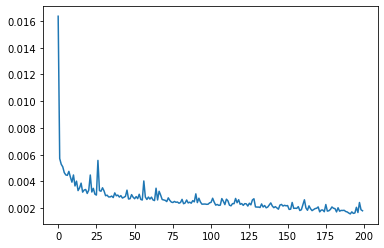

In [11]:
loss_values = history.history['loss']

# print out the loss values for each epoch
for i in range(len(loss_values)):
    print("Epoch:", i + 1, "Loss:", loss_values[i])
    
plt.plot(loss_values)

In [12]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

5/5 [==============================] - 0s 3ms/step
[0.43643084] [0.43074835]
[0.43520358] [0.38085934]
[0.41609728] [0.38049494]
[0.36575317] [0.35909498]
[0.3653757] [0.36154638]
[0.3519063] [0.37638719]
[0.35893312] [0.320966]
[0.40349436] [0.36853615]
[0.37054175] [0.37131879]
[0.4102679] [0.37744722]


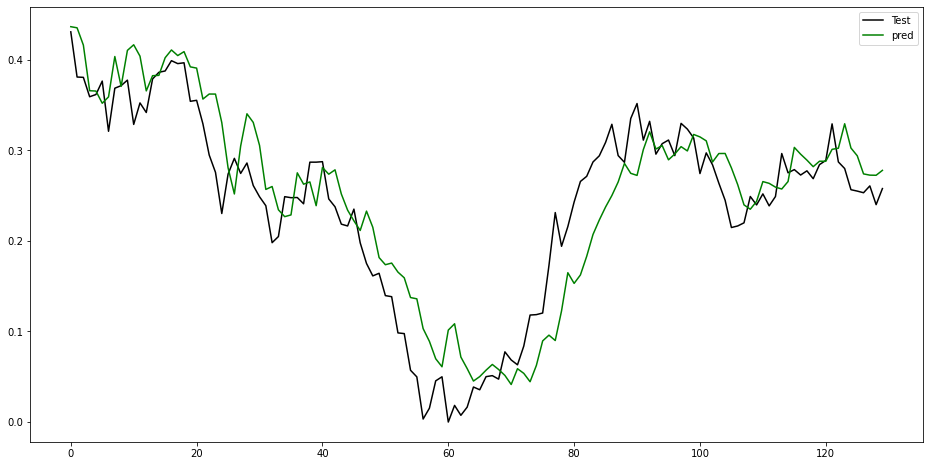

In [13]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [15]:
model.save('EveGPT')

INFO:tensorflow:Assets written to: EveGPT/assets


INFO:tensorflow:Assets written to: EveGPT/assets


In [16]:
loaded_model = keras.models.load_model('EveGPT')
loaded_model.summary()

y_pred = loaded_model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 10, 6)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               94200     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 94,351
Trainable params: 94,351
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 3ms/step
[0.43643084] [0.43074835]
[0.43520358] [0.38085934]
[0.41609728] [0.38049494]
[0.36575317] [0.35909498]
[0.3653757] [0.36154638]
[0.351906

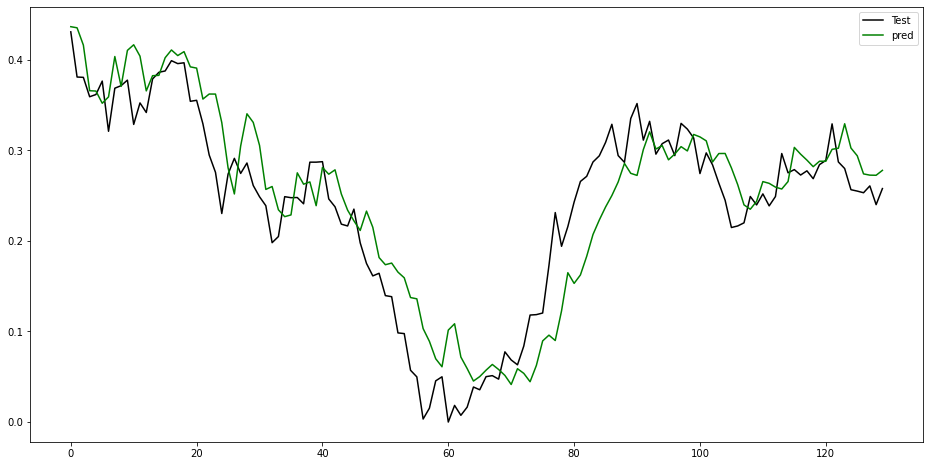

In [17]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [18]:
X_test

array([[[0.54787892, 0.30470739, 0.46324688, 0.74202013, 0.74202013,
         0.74202013],
        [0.15210887, 0.22743651, 0.4056893 , 0.74109179, 0.74109179,
         0.74109179],
        [0.57924719, 0.3978226 , 0.34898315, 0.73662374, 0.73662374,
         0.73662374],
        ...,
        [0.60911651, 0.58098118, 0.31138113, 0.71850595, 0.71850595,
         0.71850595],
        [0.39762522, 0.3937761 , 0.23115987, 0.70655576, 0.70655576,
         0.70655576],
        [0.55503187, 0.61942574, 0.26320015, 0.69728765, 0.69728765,
         0.69728765]],

       [[0.15210887, 0.22743651, 0.4056893 , 0.74109179, 0.74109179,
         0.74109179],
        [0.57924719, 0.3978226 , 0.34898315, 0.73662374, 0.73662374,
         0.73662374],
        [0.67047852, 0.65168492, 0.35203806, 0.73262854, 0.73262854,
         0.73262854],
        ...,
        [0.39762522, 0.3937761 , 0.23115987, 0.70655576, 0.70655576,
         0.70655576],
        [0.55503187, 0.61942574, 0.26320015, 0.69728765, 0.697